In [1]:
#importing 
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
# function for wrangling our data, loading and processing our data  
def wrangle(filepath):
  #reading data
  df=pd.read_csv(filepath)
  #filtering only city of Ahmedabad since it has largest observation
  df_mask= df["City"] =="Ahmedabad"
  df=df[df_mask]
  # for this project only intersted in value of pm2.5
  df=df.drop(columns=['City', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],axis=1)
  #changing datetime to its format
  df['Datetime'] = pd.to_datetime(df['Datetime'])
  # setting index to datetime
  df= df.set_index("Datetime")
  #localize timezone                                 
  df.index =df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
  #removing outliers in PM2.5 reading
  df=df[df["PM2.5"]<800]
  #removing null values and 
  df=df['PM2.5'].resample('1H').mean().fillna(method ='ffill').to_frame()
  #creating lags and droping nan
  df["PM2.L1"]= df["PM2.5"].shift(1)
  df.dropna(inplace =True)
  
  return df


In [4]:
#specifying our data path
df= wrangle("/content/drive/MyDrive/air quality/city_hour.csv")
df.tail()

,PM2.5,PM2.L1
Datetime,,
2020-07-01 01:00:00+05:30,42.92,46.55
2020-07-01 02:00:00+05:30,44.41,42.92
2020-07-01 03:00:00+05:30,33.68,44.41
2020-07-01 04:00:00+05:30,56.86,33.68
2020-07-01 05:00:00+05:30,37.63,56.86


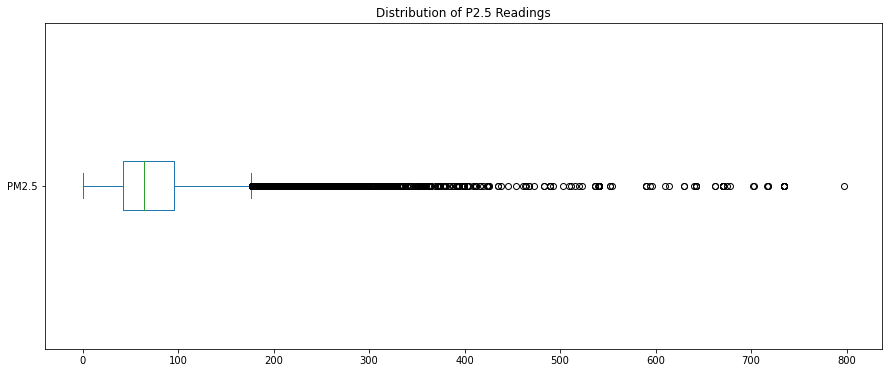

In [ ]:
#ploting box plot and see if thair is any outlier
fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].plot(kind='box',vert =False,title='Distribution of P2.5 Readings',ax=ax)

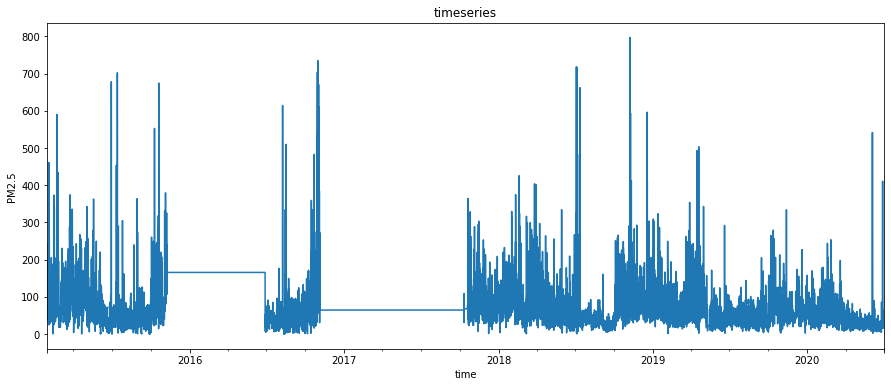

In [ ]:
#time_series plot of PM2.5
fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].plot(ax=ax,xlabel='time',ylabel='PM2.5',title='timeseries')


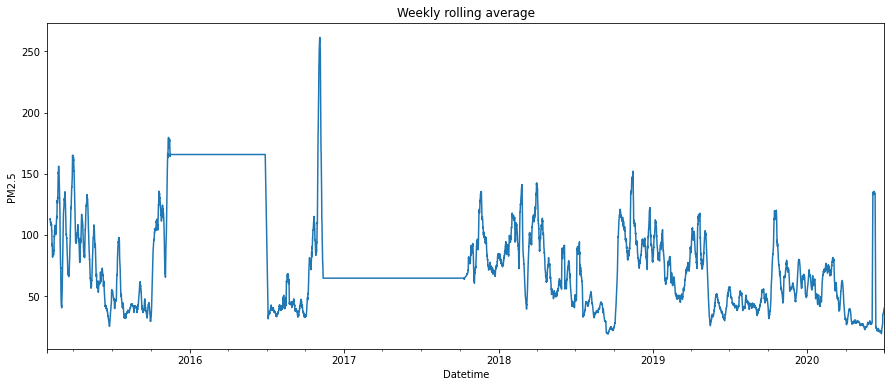

In [ ]:
# creating rolling average of the week to just understand the data better
fig, ax = plt.subplots(figsize=(15, 6))

df["PM2.5"].rolling(168).mean().plot(ax=ax,ylabel='PM2.5',title ='Weekly rolling average')

In [ ]:
# examping autocorrelation
df.corr()

,PM2.5,PM2.L1
PM2.5,1.000000,0.936962
PM2.L1,0.936962,1.000000


Text(0.5, 1.0, 'autocorrelation')

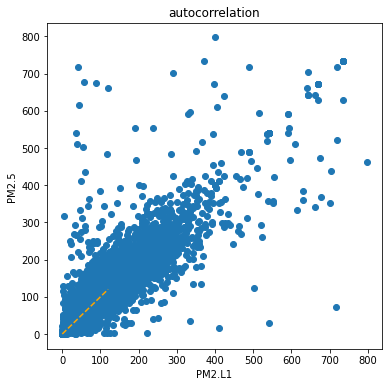

In [ ]:
# ploting auto correlation in scatter plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["PM2.L1"],y=df["PM2.5"])
ax.plot([0,120],[0,120],linestyle= '--',color ='orange')
plt.xlabel("PM2.L1")
plt.ylabel("PM2.5")
plt.title("autocorrelation")

In [7]:
#spliting our data in to feature and target
target = "PM2.5"
y = df[target]
X = df.drop(columns=target)
X.shape

(47526, 1)

In [8]:
# spliting features in data in to training and testing data on scale of 80,20
cutoff = int(len(X)*0.8)

X_train, y_train = X.iloc[:cutoff],y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:],y.iloc[cutoff:]

In [ ]:
#just to check what we did
len(X)==len(X_train) +len(X_test)

True

In [ ]:
# creating baseline model for our future reference
y_mean =y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 85.93
Baseline MAE: 44.06


In [ ]:
# instanciating a linear regression model  & fitting it using our data
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
#evaluation
training_mae = mean_absolute_error(y_train,model.predict(X_train))

test_mae = mean_absolute_error(y_test,model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 9.74
Test MAE: 8.73


In [ ]:
# extracting intercept and cofficent
intercept=model.intercept_.round(2)
coefficient =model.coef_.round(2)

print(f"P2 = {intercept} + ({coefficient} * PM2.L1)")

P2 = 5.78 + ([0.93] * PM2.L1)


In [ ]:
#dataframe to see the predicted and actual truth value of the test set
df_pred_test = pd.DataFrame(
{
    "y_test":y_test,
    "y_pred":model.predict(X_test)
}
)
df_pred_test.head()

,y_test,y_pred
Datetime,,
2019-06-01 04:00:00+05:30,44.64,45.458076
2019-06-01 05:00:00+05:30,53.92,47.416857
2019-06-01 06:00:00+05:30,44.93,56.072806
2019-06-01 07:00:00+05:30,41.53,47.687356
2019-06-01 08:00:00+05:30,49.02,44.515995


In [ ]:
# line plot for our test_predictions
fig = px.line(df_pred_test,labels={"value":"PM2.5"})
fig.show()

#Auto Regressive model
we try to use linear regression model in the above and it is good but we might try to make it a little better using other algorithem

#explore
let's see how to our target value correlate with itself and some time shifts other than 1H 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [10]:
# function for wrangling our data, loading and processing our data  
def wrangle(filepath):
  #reading data
  df=pd.read_csv(filepath)
  #filtering only city of Ahmedabad since it has largest observation
  df_mask= df["City"] =="Ahmedabad"
  df=df[df_mask]
  # for this project only intersted in value of pm2.5
  df=df.drop(columns=['City', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],axis=1)
  #changing datetime to its format
  df['Datetime'] = pd.to_datetime(df['Datetime'])
  # setting index to datetime
  df= df.set_index("Datetime")
  #localize timezone                                 
  df.index =df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
  #removing outliers in PM2.5 reading
  df=df[df["PM2.5"]<800]
  #removing null values and 
  y = df["PM2.5"].resample("1H").mean().fillna(method='ffill')
  y.dropna()

  
  return y


In [11]:
#specifying our data path
y= wrangle("/content/drive/MyDrive/air quality/city_hour.csv")
y.tail()

Datetime
2020-07-01 01:00:00+05:30    42.92
2020-07-01 02:00:00+05:30    44.41
2020-07-01 03:00:00+05:30    33.68
2020-07-01 04:00:00+05:30    56.86
2020-07-01 05:00:00+05:30    37.63
Freq: H, Name: PM2.5, dtype: float64

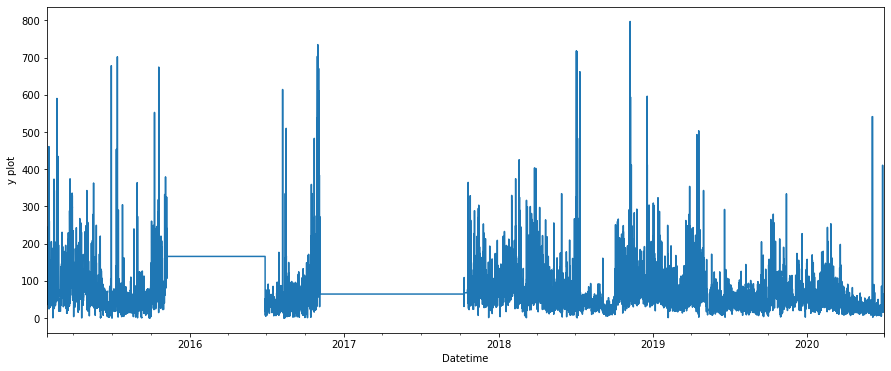

In [12]:
#line plot for visualizing our y
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(ax=ax,ylabel ='y plot')

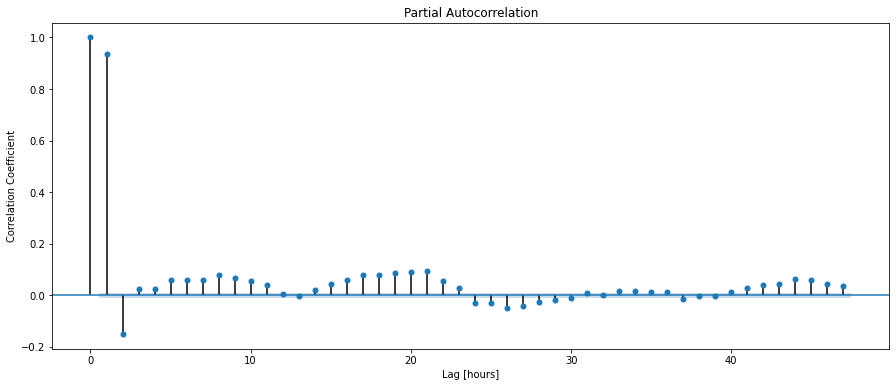

In [76]:
# removes the "echo" in our time and actualy tell us which lags should to consider and and and which to avoid.
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [77]:
#Spliting our data
cutoff = int(len(y)*0.95)

y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

In [78]:
len(y_train)+len(y_test) ==len(y)

True

#Baseline Model

In [79]:
#baseline model
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean PM2.5 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean PM2.5 Reading: 81.16
Baseline MAE: 41.35


#AutoReg model

In [80]:
#instanciating our autoreg model  lags represent how many hourso lags  should we consider for training and from our PACF plot we can say up to 23 
model = AutoReg(y_train,lags=23,old_names=False).fit()

In [81]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[23:],y_pred);
print("Training MAE:", training_mae)

Training MAE: 8.391159482097388


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [82]:
#calculating residuals which are the idffrence between observed-predicted values
y_train_resid = model.resid
y_train_resid.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Datetime
2020-03-24 00:00:00+05:30    -6.681575
2020-03-24 01:00:00+05:30    -4.810964
2020-03-24 02:00:00+05:30   -25.238821
2020-03-24 03:00:00+05:30   -11.827852
2020-03-24 04:00:00+05:30     5.800871
Freq: H, dtype: float64

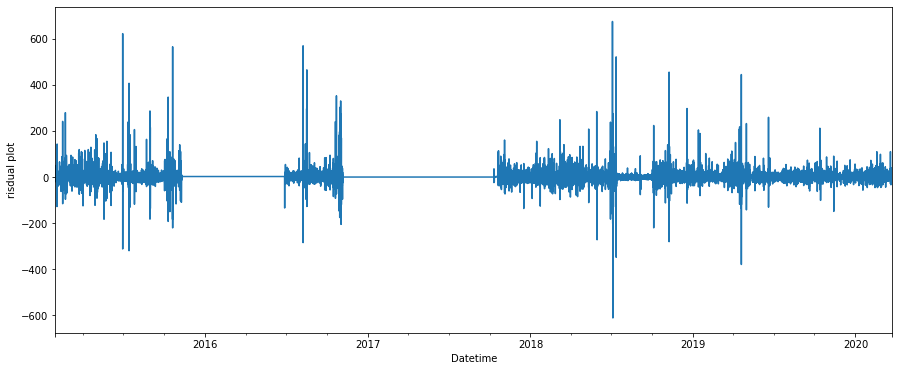

In [83]:
# ploting our residuals
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ax=ax,ylabel ='risdual plot')


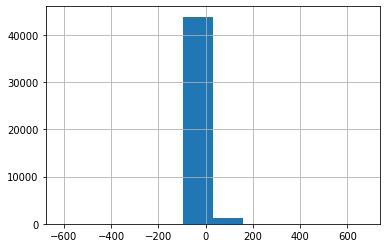

In [66]:
# histogram
y_train_resid.hist()

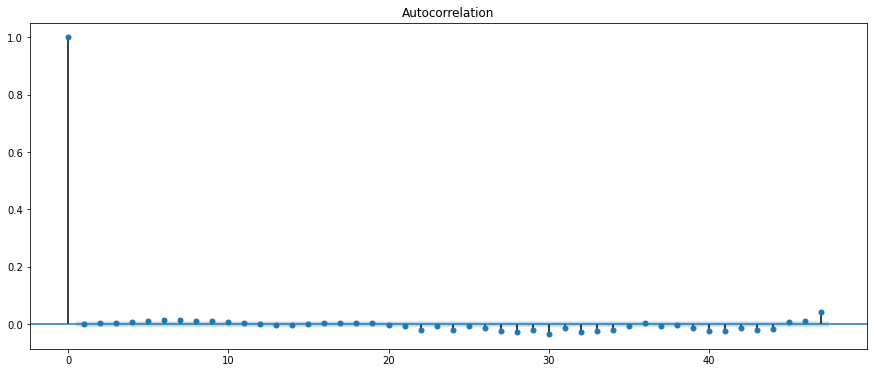

In [67]:
#creating acf for residuals
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax);

#Model Evaluation
on a test set

In [68]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 56.81660439927652


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [69]:
#creating df for both y_test and y_pred_test
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [70]:
# time series plot just to visualize the above
fig = px.line(df_pred_test, labels={"value": "PM2.5"})
fig.show()

as we can see our model is not good so problem is our validation so what we should do is using other moethods in this case is we use walk forward validation

In [37]:
# walk-froward-validation
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=23).fit()
    next_pred = model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history =history.append(y_test[next_pred.index])

In [40]:
#calculating MAE of our test
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 6.95


In [41]:
# accessing model parameters
print(model.params)

intercept    1.842475
PM2.5.L1     1.012764
PM2.5.L2    -0.160669
PM2.5.L3     0.010834
PM2.5.L4    -0.026741
PM2.5.L5     0.003491
PM2.5.L6     0.006414
PM2.5.L7    -0.013896
PM2.5.L8     0.010718
PM2.5.L9     0.007149
PM2.5.L10    0.009011
PM2.5.L11    0.030119
PM2.5.L12    0.009521
PM2.5.L13   -0.014177
PM2.5.L14   -0.013901
PM2.5.L15   -0.006482
PM2.5.L16   -0.009517
PM2.5.L17    0.011417
PM2.5.L18    0.003856
PM2.5.L19    0.006302
PM2.5.L20    0.001897
PM2.5.L21    0.041726
PM2.5.L22    0.028763
PM2.5.L23    0.028023
dtype: float64


In [42]:
#creating a line plot of our wfv and see our result clearly
f_pred_test =pd.DataFrame(
{
    "y_test":y_test,"y_pred_wfv":y_pred_wfv
})
fig = px.line(f_pred_test,labels={'value':"PM2.5"})
fig.show()

well as we can see our prediction line is following our actual and it is a good news for us.

